# Bigram LM with single digit prediction

In [1]:
words = open("names.txt", 'r').read().splitlines()

In [2]:
words[0:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
min(len(w) for w in words)

2

In [5]:
max(len(w) for w in words)

15

In [6]:
special_start_char = '<S>'
special_end_char = '<E>'
bigram_counts = dict()
for w in words:
    characters = [special_start_char] + list(w) + [special_end_char] 
    for ch1, ch2 in zip(characters, characters[1:]):
        bigram = (ch1, ch2)
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1

In [7]:
sorted(bigram_counts.items(), key=lambda kv: -kv[1])[0:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [8]:
import torch
different_chars_in_dataset = sorted(list(set(''.join(words))))
number_of_different_chars=len(different_chars_in_dataset)+1
bigram_counts_tensor = torch.zeros((number_of_different_chars,number_of_different_chars), dtype=torch.int32)

In [9]:
special_char = '.'
mapping_char_to_index = {s:i+1 for i,s in enumerate(different_chars_in_dataset)}
mapping_char_to_index[special_char] = 0
mapping_index_to_char = {i:s for s,i in mapping_char_to_index.items()}

In [10]:
for w in words:
    characters = [special_char] + list(w) + [special_char] 
    for ch1, ch2 in zip(characters, characters[1:]):
        bigram_counts_tensor[mapping_char_to_index[ch1], mapping_char_to_index[ch2]] += 1

In [11]:
bigram_counts_tensor

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

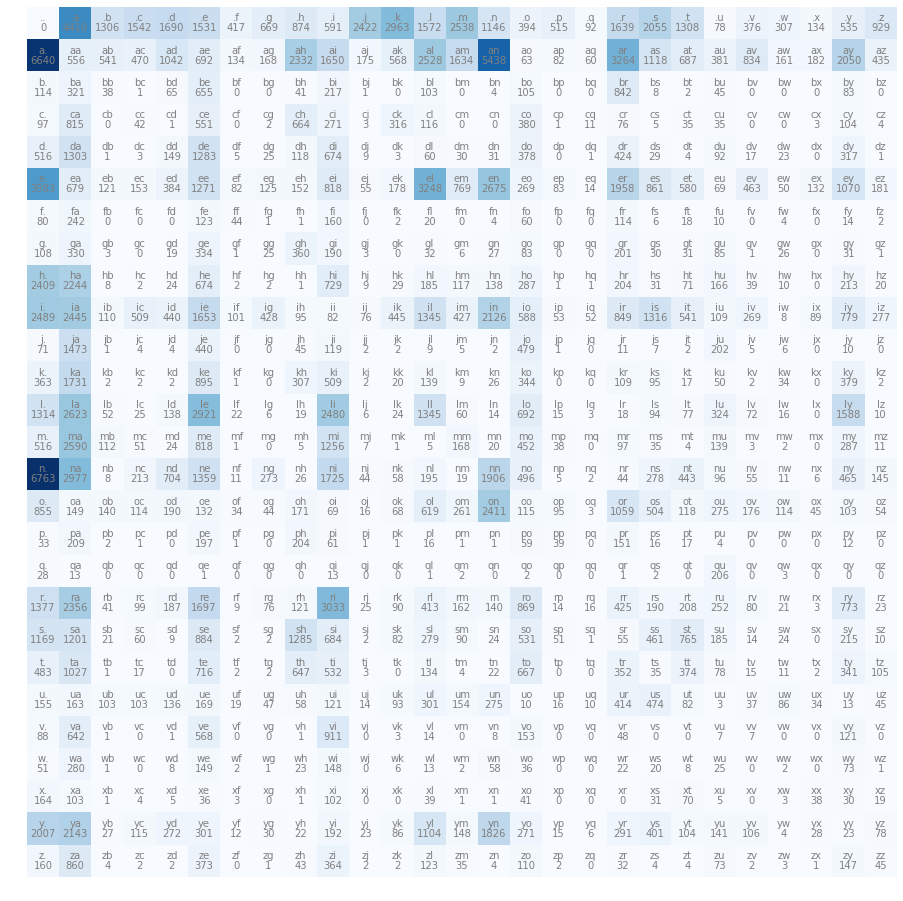

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(bigram_counts_tensor, cmap='Blues')
for i in range(len(mapping_char_to_index)):
    for j in range(len(mapping_char_to_index)):
        chstr = mapping_index_to_char[i] + mapping_index_to_char[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, bigram_counts_tensor[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [13]:
bigram_counts_tensor[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [14]:
probabilities_for_first_char = bigram_counts_tensor[0].float() / bigram_counts_tensor[0].float().sum()

In [15]:
probabilities_for_first_char

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [16]:
# Tensor manipulation
bigram_probabilities = bigram_counts_tensor.float()
bigram_probabilities.shape

torch.Size([27, 27])

In [17]:
bigram_probabilities.sum()

tensor(228146.)

In [18]:
# We want to have the sum by row
# keep dims = false, dimension squeezed out
bigram_probabilities.sum(0).shape

torch.Size([27])

In [19]:
# We want to have the sum by row
# keep dims = false, dimension squeezed out
bigram_probabilities.sum(0, keepdim=True).shape

torch.Size([1, 27])

In [20]:
bigram_probabilities.sum(1, keepdim=True).shape

torch.Size([27, 1])

In [21]:
# broadcasting
# can i divide 27,27 by a 27,1 array?
# go right to left
# each dimension must be either equal, either equals to 1, either do not exist
# when dimension is 1, it copies the element 27 times


In [22]:
#bigram_probabilities = bigram_counts_tensor.float() / bigram_counts_tensor.float().sum(dim=1, keepdim=True)
# model smoothing, add one to add value in the counts, that avoids infinite loss for bigrams never seen in the training set
bigram_probabilities = (bigram_counts_tensor + 1).float()
bigram_probabilities = bigram_probabilities / bigram_probabilities.sum(dim=1, keepdim=True)
bigram_probabilities.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [23]:
g = torch.Generator().manual_seed(2147483647)
generated_words = []
for i in range(10):
    generated_word = ""
    index_of_sampled_char = 0
    finished_generating = False
    while not finished_generating:
        index_of_sampled_char = torch.multinomial(bigram_probabilities[index_of_sampled_char], num_samples=1, replacement=True, generator=g).item()
        if index_of_sampled_char == 0:
            finished_generating = True
        else:
            generated_word = generated_word + mapping_index_to_char[index_of_sampled_char]
    generated_words.append(generated_word)
    

In [24]:
generated_words

['mor',
 'axx',
 'minaymoryles',
 'kondlaisah',
 'anchshizarie',
 'odaren',
 'iaddash',
 'h',
 'jhinatien',
 'egushl']

In [25]:
# Model evaluation

In [26]:
# We will look at the probabilities for each bigram

In [27]:
log_likelihood = 0
number_of_bigrams = 0
for w in words:
    characters = [special_char] + list(w) + [special_char] 
    for ch1, ch2 in zip(characters, characters[1:]):
        probability_for_bigram = bigram_probabilities[mapping_char_to_index[ch1], mapping_char_to_index[ch2]]
        log_likelihood += torch.log(probability_for_bigram)
        number_of_bigrams += 1
loss = -log_likelihood / number_of_bigrams
print(loss)

tensor(2.4544)


## Exercises
E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

# Neural network

In [28]:
xs, ys = [], []
for w in words:
    characters = [special_char] + list(w) + [special_char] 
    for ch1, ch2 in zip(characters, characters[1:]):
        xs.append(mapping_char_to_index[ch1])
        ys.append(mapping_char_to_index[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)
        

In [29]:
xs

tensor([ 0,  5, 13,  ..., 25, 26, 24])

In [30]:
ys

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [31]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=len(mapping_char_to_index)).float()

In [32]:
xenc.shape

torch.Size([228146, 27])

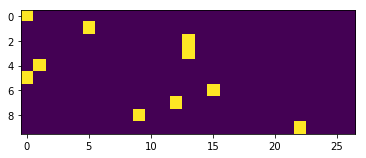

In [33]:
plt.imshow(xenc[:10])

In [34]:
# weights
W = torch.randn(xenc.shape[1],xenc.shape[1], requires_grad=True)
W

tensor([[ 3.0329e-01,  9.8675e-01, -2.6890e-01, -1.2800e+00,  6.6104e-01,
          6.7636e-01,  8.3597e-01,  2.0640e+00, -1.0948e+00, -4.8979e-02,
         -2.1452e+00, -7.2141e-01, -3.8069e-01,  7.1529e-01,  4.2151e-01,
         -8.2867e-01, -2.0111e-01,  3.0373e-01, -1.0422e-01, -1.4037e-01,
         -3.4186e-01, -9.9124e-01, -6.1659e-04,  4.1824e-01,  3.6846e-01,
         -1.5507e+00, -3.2525e-01],
        [-1.1761e+00,  6.0115e-01,  1.0643e+00, -2.0646e-01,  4.7832e-01,
          1.0861e+00, -7.7600e-01, -6.4892e-01,  9.4257e-01, -1.0969e+00,
          6.7864e-01, -8.3323e-01, -1.0272e+00,  1.1134e+00, -2.4898e+00,
         -9.8822e-02,  1.1152e+00, -1.3113e+00, -8.0838e-01,  9.3124e-01,
         -5.6650e-01, -5.5776e-02,  7.3668e-01, -1.0721e+00,  2.1715e-01,
         -1.5280e+00, -4.2126e-01],
        [ 4.4941e-01, -5.8919e-01, -5.3787e-01,  7.9615e-01, -2.0097e-01,
          1.4841e+00,  7.4907e-01,  2.8756e-01,  8.4407e-01, -4.4497e-01,
          1.2809e+00,  9.6940e-01, -1.04

In [35]:
# @ is matrix multiplication in pytorch
# Firing of 13th neuron for the 3rd input
(xenc @ W)[3,13]

tensor(2.2043, grad_fn=<SelectBackward>)

In [36]:
# xenc @ W is the equivalent of the log of the counts we saw on the table on first step
logits = xenc @ W # log counts
counts = logits.exp()
probabilities = counts / counts.sum(1, keepdims=True)


TypeError: sum() received an invalid combination of arguments - got (int, keepdims=bool), but expected one of:
 * ()
 * (torch.dtype dtype)
 * (tuple of ints dim, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: keepdims
 * (tuple of ints dim, bool keepdim, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: keepdims


In [ ]:
probabilities[0].sum()

In [ ]:
# calculate the loss
losses = torch.zeros(probabilities.shape[0])
for i in range(probabilities.shape[0]):
    x = xs[i].item()
    y = ys[i].item()
    probability_for_combination = probabilities[i, y]
    loss_for_item = -torch.log(probability_for_combination)
    losses[i] = loss_for_item
loss = losses.mean().item()
loss

As we can see the loss of our NN is much higher than with the count based model

In [ ]:
# vectorized loss
probabilities_for_actual_chars = probabilities[torch.arange(probabilities.shape[0]), ys]
loss = -probabilities_for_actual_chars.log().mean()
loss

In [ ]:
# backward pass
W.grad = None # set gradient to zero
loss.backward()

In [ ]:
loss

In [ ]:
W.grad

W.grad[0,0] is positive which means that increasing its value will increase the loss 

In [ ]:
# update the weights
W.data += W.grad * -0.1

In [ ]:
# recalculate the loss
logits = xenc @ W # log counts
counts = logits.exp()
probabilities = counts / counts.sum(1, keepdims=True)
probabilities_for_actual_chars = probabilities[torch.arange(probabilities.shape[0]), ys]
loss = -probabilities_for_actual_chars.log().mean()
loss

In [ ]:
import torch.nn.functional as F
import torch

words = open("names.txt", 'r').read().splitlines()
special_char = '.'
different_chars_in_dataset = sorted(list(set(''.join(words))))
mapping_char_to_index = {s:i+1 for i,s in enumerate(different_chars_in_dataset)}
mapping_char_to_index[special_char] = 0
mapping_index_to_char = {i:s for s,i in mapping_char_to_index.items()}

losses = []
xs, ys = [], []
for w in words:
    characters = [special_char] + list(w) + [special_char] 
    for ch1, ch2 in zip(characters, characters[1:]):
        xs.append(mapping_char_to_index[ch1])
        ys.append(mapping_char_to_index[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xenc = F.one_hot(xs, num_classes=len(mapping_char_to_index)).float()
W = torch.randn(xenc.shape[1],xenc.shape[1], requires_grad=True)

# Let's run a for loop
for i in range(100):
    # forward pass
    # W.exp is the equivalent to the nth line of thte table 
    # Incentivizing W to be close to 0 is a way to smooth the distribution exp(0) = 1
    logits = xenc @ W # log counts
    counts = logits.exp()
    probabilities = counts / counts.sum(1, keepdims=True)
    probabilities_for_actual_chars = probabilities[torch.arange(probabilities.shape[0]), ys]
    # 0.01*(W**2).mean() is the regularization term, closer W is to 0, smaller this will be and lower will be the loss 
    # so at the same time we want the weights to match the distribution but as well to have W small
    loss = -probabilities_for_actual_chars.log().mean() + 0.01*(W**2).mean()
    losses.append(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # weight update
    W.data += W.grad * -10 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(losses)), losses)

In [ ]:
print(losses[-1])

In [37]:
torch.version

<module 'torch.version' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torch/version.py'>